In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns
import geopandas as gpd

plt.style.use('ggplot')
pd.set_option('display.max_columns', 30)

In [2]:
df = pd.read_csv('data/citibike_ZIP.csv')
df.head()

,tripduration,starttime,stoptime,start_id,start_name,start_lat,start_lon,end_id,end_name,end_lat,end_lon,bikeid,usertype,birth_year,gender,start_count,end_count,geometry,zip_start,zip_end
0,17.700000,2020-06-01 00:00:03.372,2020-06-01 00:17:46.208,3419,Douglass St & 4 Ave,40.679279,-73.981540,3419,Douglass St & 4 Ave,40.679279,-73.981540,39852,Customer,1997,2,614,634,POINT (989370.1838770027 186756.53892500512),11217,11217.0
1,63.500000,2020-06-01 00:00:03.553,2020-06-01 01:03:33.936,366,Clinton Ave & Myrtle Ave,40.693261,-73.968896,336,Sullivan St & Washington Sq,40.730477,-73.999061,37558,Subscriber,1969,0,1713,5220,POINT (992875.4144866021 191851.65323921342),11205,10012.0
2,16.950000,2020-06-01 00:00:09.614,2020-06-01 00:17:06.833,389,Broadway & Berry St,40.710446,-73.965251,3562,Classon Ave & St Marks Ave,40.676520,-73.959608,37512,Customer,1988,2,2709,1310,POINT (993883.8241576733 198112.87322040228),11249,11238.0
3,3.766667,2020-06-01 00:00:12.178,2020-06-01 00:03:58.864,3255,8 Ave & W 31 St,40.750585,-73.994685,505,6 Ave & W 33 St,40.749013,-73.988484,39674,Customer,1969,0,4128,4835,POINT (985722.6805079061 212735.19209770544),10001,10001.0
4,23.950000,2020-06-01 00:00:21.255,2020-06-01 00:24:18.965,367,E 53 St & Lexington Ave,40.758281,-73.970694,497,E 17 St & Broadway,40.737050,-73.990093,21093,Customer,1997,2,2726,7575,POINT (992368.8021711168 215540.1540624901),10022,10003.0


In [3]:
# convert to geo dataframe
start_gpd = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(
    df['start_lon'], df['start_lat']), crs = 'epsg:4326')

# update projection 
start_gpd.to_crs(epsg=2263, inplace = True)

In [4]:
# convert start and stop to datetime
start_gpd['starttime'] = pd.to_datetime(start_gpd['starttime'])
start_gpd['stoptime'] = pd.to_datetime(start_gpd['stoptime'])

In [42]:
# supply and demand

starts_hrly = start_gpd.groupby(['hour','start_id'], as_index = False)[['bikeid']].count()
starts_hrly.columns = ['hour','start_id','start_count']
starts_hrly

,hour,start_id,start_count
0,0,72,45
1,0,79,11
2,0,82,4
3,0,83,35
4,0,116,32
...,...,...,...
22045,23,4020,45
22046,23,4023,26
22047,23,4036,19
22048,23,4037,5


In [43]:
ends_hrly = start_gpd.groupby(['hour','end_id'], as_index = False)[['bikeid']].count()
ends_hrly.columns = ['hour','end_id','end_count']
ends_hrly

,hour,end_id,end_count
0,0,72,53
1,0,79,8
2,0,82,10
3,0,83,17
4,0,116,40
...,...,...,...
22065,23,4021,1
22066,23,4023,40
22067,23,4036,11
22068,23,4037,8


In [44]:
supply_hrly = starts_hrly.merge(ends_hrly,
                               left_on = ['hour','start_id'],
                               right_on = ['hour','end_id'],
                               how = 'outer')
supply_hrly.head(10)

,hour,start_id,start_count,end_id,end_count
0,0,72.0,45.0,72.0,53.0
1,0,79.0,11.0,79.0,8.0
2,0,82.0,4.0,82.0,10.0
3,0,83.0,35.0,83.0,17.0
4,0,116.0,32.0,116.0,40.0
5,0,119.0,23.0,119.0,21.0
6,0,120.0,14.0,120.0,7.0
7,0,127.0,39.0,127.0,20.0
8,0,128.0,72.0,128.0,62.0
9,0,143.0,19.0,143.0,19.0


In [45]:
supply_hrly[supply_hrly['end_count'].isnull()]
supply_hrly['end_count'].fillna(0, inplace=True)

In [46]:
supply_hrly[supply_hrly['start_count'].isnull()]
supply_hrly['start_count'].fillna(0, inplace=True)

In [47]:
# define hourly surplus as the difference between hourly end count and start count at a station

supply_hrly['hrly_surplus'] = (supply_hrly['end_count'] - supply_hrly['start_count'])/30
supply_hrly.head()

,hour,start_id,start_count,end_id,end_count,hrly_surplus
0,0,72.0,45.0,72.0,53.0,0.266667
1,0,79.0,11.0,79.0,8.0,-0.100000
2,0,82.0,4.0,82.0,10.0,0.200000
3,0,83.0,35.0,83.0,17.0,-0.600000
4,0,116.0,32.0,116.0,40.0,0.266667


In [48]:
zip_shp = gpd.read_file('nyc_zip/ZIP_CODE_040114.shp')

In [49]:
zip_shp['ZIPCODE'] = zip_shp['ZIPCODE'].astype(int)

In [50]:
rides_AM = supply_hrly[(supply_hrly['hour'] > 4) & (supply_hrly['hour'] < 11)] # 5-10 am
rides_PM = supply_hrly[(supply_hrly['hour'] > 15) & (supply_hrly['hour'] < 22)] # 4-9 pm

In [52]:
count_AM = rides_AM.groupby('start_id', as_index = False)['start_count','end_count'].sum()
count_AM.columns = ['station_id','start_AM','end_AM']
count_PM = rides_PM.groupby('end_id', as_index = False)['start_count','end_count'].sum()
count_PM.columns = ['station_id','start_PM','end_PM']
count_PM.head()

/var/folders/br/94g31g292jj5vykvq71cy53m0000gn/T/ipykernel_65450/3184407353.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  count_AM = rides_AM.groupby('start_id', as_index = False)['start_count','end_count'].sum()
/var/folders/br/94g31g292jj5vykvq71cy53m0000gn/T/ipykernel_65450/3184407353.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  count_PM = rides_PM.groupby('end_id', as_index = False)['start_count','end_count'].sum()


,station_id,start_PM,end_PM
0,72.0,2477.0,2581.0
1,79.0,664.0,632.0
2,82.0,557.0,547.0
3,83.0,1256.0,1119.0
4,116.0,1852.0,2083.0


In [56]:
commute_count = count_AM.merge(count_PM, on = 'station_id')
commute_count['surplus_AM'] = commute_count['end_AM'] - commute_count['start_AM']
commute_count['surplus_PM'] = commute_count['end_PM'] - commute_count['start_PM']
commute_count['surplus_AM_daily'] = commute_count['surplus_AM']/30
commute_count['surplus_PM_daily'] = commute_count['surplus_PM']/30
commute_count.head()

,station_id,start_AM,end_AM,start_PM,end_PM,surplus_AM,surplus_PM,surplus_AM_daily,surplus_PM_daily
0,72.0,1009.0,866.0,2477.0,2581.0,-143.0,104.0,-4.766667,3.466667
1,79.0,247.0,318.0,664.0,632.0,71.0,-32.0,2.366667,-1.066667
2,82.0,181.0,162.0,557.0,547.0,-19.0,-10.0,-0.633333,-0.333333
3,83.0,222.0,322.0,1256.0,1119.0,100.0,-137.0,3.333333,-4.566667
4,116.0,765.0,534.0,1852.0,2083.0,-231.0,231.0,-7.700000,7.700000


In [61]:
gpd_sub = start_gpd.drop_duplicates(['start_id'])
gpd_sub.shape

(958, 22)

In [62]:
gpd_sub = gpd_sub.merge(commute_count,
                        left_on = 'start_id', 
                       right_on = 'station_id',
                       how = 'left')
gpd_sub.head()

,tripduration,starttime,stoptime,start_id,start_name,start_lat,start_lon,end_id,end_name,end_lat,end_lon,bikeid,usertype,birth_year,gender,...,end_count,geometry,zip_start,zip_end,weekday,hour,station_id,start_AM,end_AM,start_PM,end_PM,surplus_AM,surplus_PM,surplus_AM_daily,surplus_PM_daily
0,17.700000,2020-06-01 00:00:03.372,2020-06-01 00:17:46.208,3419,Douglass St & 4 Ave,40.679279,-73.981540,3419,Douglass St & 4 Ave,40.679279,-73.981540,39852,Customer,1997,2,...,634,POINT (989370.184 186756.539),11217,11217.0,0,0,3419.0,97.0,77.0,295.0,310.0,-20.0,15.0,-0.666667,0.500000
1,63.500000,2020-06-01 00:00:03.553,2020-06-01 01:03:33.936,366,Clinton Ave & Myrtle Ave,40.693261,-73.968896,336,Sullivan St & Washington Sq,40.730477,-73.999061,37558,Subscriber,1969,0,...,5220,POINT (992875.414 191851.653),11205,10012.0,0,0,366.0,353.0,229.0,630.0,763.0,-124.0,133.0,-4.133333,4.433333
2,16.950000,2020-06-01 00:00:09.614,2020-06-01 00:17:06.833,389,Broadway & Berry St,40.710446,-73.965251,3562,Classon Ave & St Marks Ave,40.676520,-73.959608,37512,Customer,1988,2,...,1310,POINT (993883.824 198112.873),11249,11238.0,0,0,389.0,451.0,369.0,1078.0,1209.0,-82.0,131.0,-2.733333,4.366667
3,3.766667,2020-06-01 00:00:12.178,2020-06-01 00:03:58.864,3255,8 Ave & W 31 St,40.750585,-73.994685,505,6 Ave & W 33 St,40.749013,-73.988484,39674,Customer,1969,0,...,4835,POINT (985722.681 212735.192),10001,10001.0,0,0,3255.0,1161.0,1055.0,1534.0,1634.0,-106.0,100.0,-3.533333,3.333333
4,23.950000,2020-06-01 00:00:21.255,2020-06-01 00:24:18.965,367,E 53 St & Lexington Ave,40.758281,-73.970694,497,E 17 St & Broadway,40.737050,-73.990093,21093,Customer,1997,2,...,7575,POINT (992368.802 215540.154),10022,10003.0,0,0,367.0,585.0,1082.0,1025.0,681.0,497.0,-344.0,16.566667,-11.466667


In [33]:
man_zip = zip_shp.loc[zip_shp['ZIPCODE'] == 10003]
bk_zip = zip_shp.loc[zip_shp['ZIPCODE'] == 11201]

/Users/emmydanforth/anaconda3/lib/python3.10/site-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/Users/emmydanforth/anaconda3/lib/python3.10/site-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/Users/emmydanforth/anaconda3/lib/python3.10/site-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/Users/emmydanforth/anaconda3/lib/python3.10/site-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/Users/emmydanforth/anaconda3/lib/python3.10/site-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/User

[]

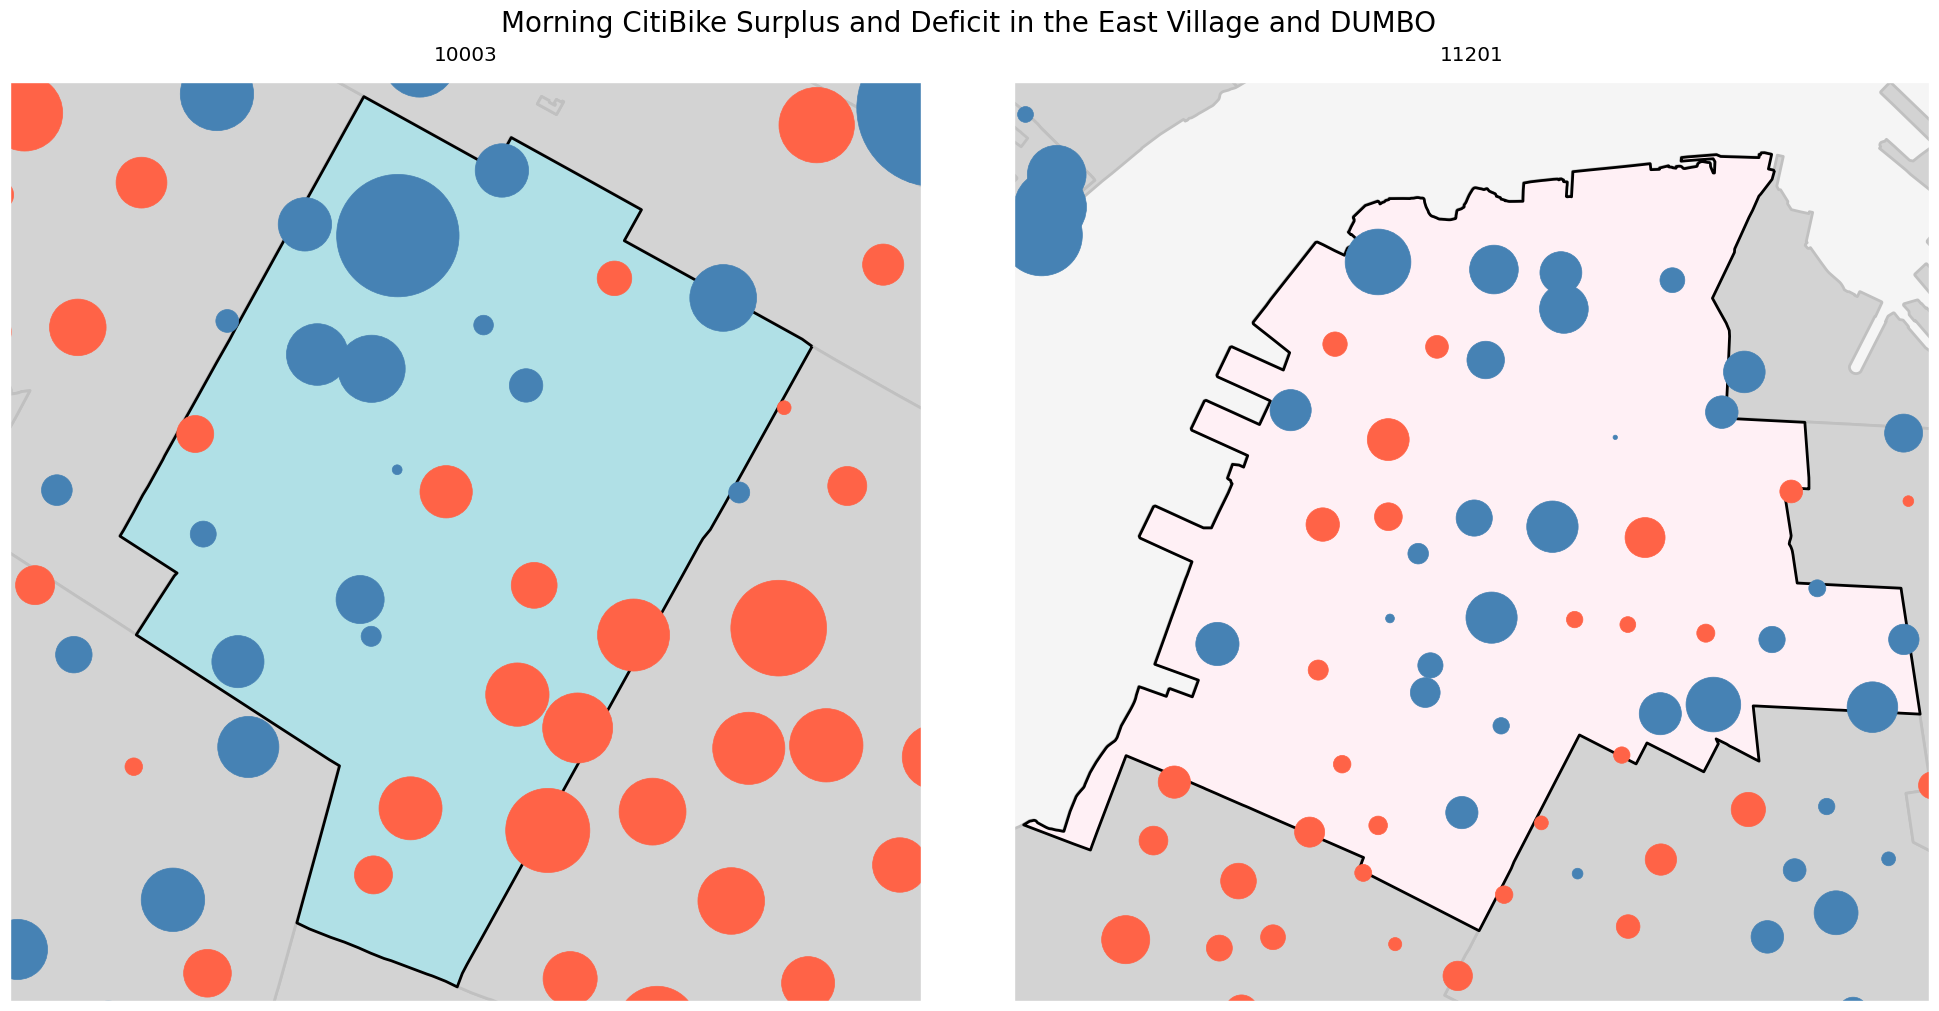

In [71]:
fig, (ax1, ax2) = plt.subplots(1,2, 
                        figsize=(20, 10),
                        sharex=False,
                        sharey=False,
                        constrained_layout=True)

fig.suptitle('Morning CitiBike Surplus and Deficit in the East Village and DUMBO', fontsize=20)

zip_shp.plot(ax=ax1, color = 'lightgrey', edgecolor = 'silver', linewidth = 2)
man_zip.plot(ax=ax1, color='powderblue', edgecolor = 'black', linewidth = 2)
gpd_sub.plot(ax=ax1, markersize = (gpd_sub['surplus_AM'])*10, color = 'steelblue')
gpd_sub.plot(ax=ax1, markersize = (gpd_sub['surplus_AM'])*(-10), color = 'tomato')

minx, miny, maxx, maxy = man_zip.total_bounds
ax1.set_xlim(minx - 750, maxx + 750)
ax1.set_ylim(miny - 100, maxy + 100)

ax1.set_title('10003', pad = 15)
ax1.set_facecolor("whitesmoke")
ax1.grid(False)
ax1.set_xticks([])
ax1.set_yticks([])

zip_shp.plot(ax=ax2, color = 'lightgrey', edgecolor = 'silver', linewidth = 2)
bk_zip.plot(ax=ax2, color='lavenderblush', edgecolor = 'black', linewidth = 2)
gpd_sub.plot(ax=ax2, markersize = (gpd_sub['surplus_AM'])*10, color = 'steelblue')
gpd_sub.plot(ax=ax2, markersize = (gpd_sub['surplus_AM'])*(-10), color = 'tomato')

minx, miny, maxx, maxy = bk_zip.total_bounds
ax2.set_xlim(minx - 100, maxx + 100)
ax2.set_ylim(miny - 750, maxy + 750)

ax2.set_title('11201', pad = 15)
ax2.set_facecolor("whitesmoke")
ax2.grid(False)
ax2.set_xticks([])
ax2.set_yticks([])